<a href="https://colab.research.google.com/github/mitkrieg/dl-assignment-1/blob/main/assignment1_practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1: DL Basics

### Goal
Implement [LeNet5](https://arxiv.org/pdf/1502.03167v3) and compare various regularization techniques on the network using the FashionMNSIT dataset.

## Download Data

In [1]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -O ./data/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -O ./data/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -O ./data/test-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -O ./data/test-labels-idx1-ubyte.gz

--2024-09-12 08:31:08--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 3.5.134.248, 52.219.170.32, 52.219.170.224, ...
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|3.5.134.248|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘./data/train-images-idx3-ubyte.gz’

./data/train-images 100%[===================>]  25.20M  1.36MB/s    in 19s     

2024-09-12 08:31:27 (1.36 MB/s) - ‘./data/train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2024-09-12 08:31:27--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.140.68, 52.219.16

## Library Imports

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import itertools
from time import time
import gzip
import typing as T
import wandb

torch.manual_seed(123)

wandb.login()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mitkrieger (mitkrieger-cornell-university). Use `wandb login --relogin` to force relogin


True

## Check for GPU Access

In [3]:
print("------ ACCELERATION INFO -----")
print('CUDA GPU Available:',torch.cuda.is_available())
print('MPS GPU Available:', torch.backends.mps.is_available())
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('GPU Name:',torch.cuda.get_device_name(0))
  print('GPU Count:',torch.cuda.device_count())
  print('GPU Memory Allocated:',torch.cuda.memory_allocated(0))
  print('GPU Memory Cached:',torch.cuda.memory_reserved(0))
# elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
#   device = torch.device('mps')
#   print('Pytorch GPU Build:',torch.backends.mps.is_built())
else:
  device = torch.device('cpu')
  print('Using CPU')

------ ACCELERATION INFO -----
CUDA GPU Available: False
MPS GPU Available: True
Using CPU


## Load Data into Pytorch

In [4]:
PATH = './data'


### Define FashionMNIST

In [5]:
class FasionMNISTDataset(Dataset):
  def __init__(self, path: str, kind: str, transform=None, target_transform=None, device=None) -> None:
    self.transform = transform
    self.target_transform = target_transform
    self.device = device
    self.labels, self.images = self._load_data(path, kind)

  def _load_data(self, path: str, kind: str) -> T.Tuple[np.ndarray, np.ndarray]:
    with gzip.open(path + f'/{kind}-labels-idx1-ubyte.gz', 'rb') as lable_file:
      lbls = np.frombuffer(lable_file.read(), dtype=np.int8, offset=8)
      lbls = np.copy(lbls)
    with gzip.open(path + f'/{kind}-images-idx3-ubyte.gz', 'rb') as lable_file:
      imgs = np.frombuffer(lable_file.read(), dtype=np.uint8, offset=16).reshape(len(lbls), 1, 28, 28)
      imgs = (np.copy(imgs) / 255).astype(np.float32)
    return lbls, imgs

  def __len__(self) -> int:
    return self.labels.size

  def __getitem__(self, index: int) -> T.Tuple[torch.tensor, torch.tensor]:
    label = torch.tensor(self.labels[index], dtype=torch.long)
    img = torch.tensor(self.images[index])
    if self.device:
      img = img.to(self.device)
      label = label.to(self.device)
    if self.target_transform:
      label = self.target_transform(label)
    if self.transform:
      img = self.transform(img)


    return img, label

def show_img(dataset: Dataset, index: int) -> None:
  img, label = dataset[index]
  labels_map = {
            0: "T-Shirt",
            1: "Trouser",
            2: "Pullover",
            3: "Dress",
            4: "Coat",
            5: "Sandal",
            6: "Shirt",
            7: "Sneaker",
            8: "Bag",
            9: "Ankle Boot",
        }
  plt.imshow(img.cpu().reshape(28,28), cmap='gray')
  plt.title(labels_map[label.cpu().item()])
  plt.show()

### Create Train, Validation and Test sets with loaders

In [6]:
gen = torch.Generator().manual_seed(123)

train = FasionMNISTDataset(PATH, 'train', device=device)
train, val = torch.utils.data.random_split(train, [0.8, 0.2], generator=gen)
test = FasionMNISTDataset(PATH, 'test', device=device)

batch = 128
trainloader = DataLoader(train, batch, shuffle=True, generator=gen)
valloader = DataLoader(val, batch, shuffle=True, generator=gen)
testloader = DataLoader(test, batch, shuffle=True, generator=gen)

dataloaders = {
    'train': trainloader,
    'val': valloader,
    'test': testloader
}

#### Example Images

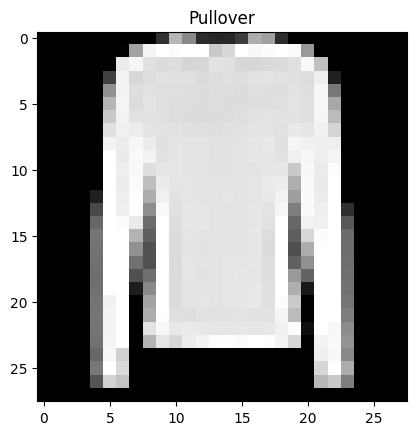

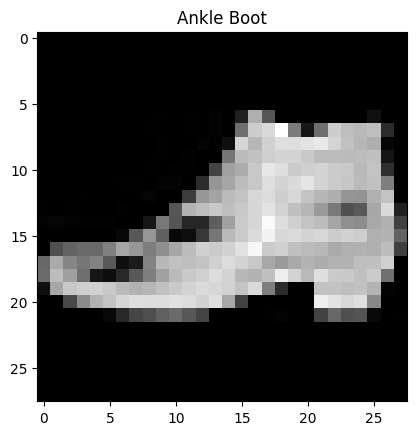

In [7]:
show_img(train, 0)
show_img(train,101)

## LeNet5

In [8]:
class Lenet5(nn.Module):
  def __init__(self, **kwargs):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
    self.max_pool1 = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.max_pool2 = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84,10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.max_pool1(x)
    x = F.relu(self.conv2(x))
    x = self.max_pool2(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

### Define Training Loop

In [9]:


def train_epoch(network, dataloader, loss_fn, optimizer, device, epoch, verbosity: int):
  """Train one epoch of a Lenet5 network"""
  
  network.train()
  batch_loss = 0
  total_loss = 0

  # iterate over all batches
  for i, data in enumerate(dataloader):
    inputs, labels = data

    optimizer.zero_grad()
    outputs = network(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    batch_loss += loss.item()
    if i % verbosity == verbosity - 1:
      print(f'Batch #{i + 1} Loss: {batch_loss / verbosity}')
      batch_loss = 0

  total_loss = 0

def eval_network(title, network, dataloader, loss_fn, epoch):
  """Evaluate model and log metrics to wandb"""

  network.eval()
  correct = 0
  total = 0
  loss = 0

  with torch.no_grad():
      for data in dataloader:
          images, labels = data
          outputs = network(images)
          _, predicted = torch.max(outputs.data, 1)

          loss += loss_fn(outputs, labels)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      accuracy = correct / total
      wandb.log({
          f'{title}-loss': loss / len(dataloader),
          f'{title}-accuracy': accuracy
      }, step=epoch)
  
  print(f'\033[92m{title} accuracy: {correct}/{total} = {100 * accuracy : .4} % ||| loss {loss / len(dataloader)}\033[0m')
  return accuracy

def train_network(network, dataloaders, loss_fn, optimizer, device, epochs: int, verbosity: int):
  """Train network for given number of epochs using optimizer and loss_fn"""

  train_accuracy, val_accuracy, test_accuracy = 0, 0, 0
  for epoch in range(epochs):
    print(f'----------- Epoch #{epoch + 1} ------------')
    train_epoch(network, dataloaders['train'], loss_fn, optimizer, device, epoch, verbosity)
    train_accuracy = eval_network('Train', network, dataloaders['train'], loss_fn, epoch)
    val_accuracy = eval_network('Validation', network, dataloaders['val'], loss_fn, epoch)    
    test_accuracy = eval_network('Test', network, dataloaders['test'], loss_fn, epoch)
    print('------------------------------------\n')
  print('----------- Train Complete! ------------')
  return {
    "train":train_accuracy,
    "val":val_accuracy,
    "test":test_accuracy,
  }


def hyperparameter_tuning(network_cls, dataloaders, device, epochs: int, **kwargs):
  """Train multiple networks and print out hyperparameters & metrics for the highest performing model based on validation accuracy"""

  ts = time()
  keys = kwargs.keys()
  best_model = None
  for i, v in enumerate(itertools.product(*kwargs.values())):
    hyperparams = dict(zip(keys, v))
    network = network_cls(**hyperparams)
    network.to(device)
    name = network._get_name() + '_' + str(ts) + '_' + str(i)
    run = wandb.init(
      id=name,
      config={
        **hyperparams
      }
    )

    print(f'XXXXXXXX Tuning Network {network._get_name()} XXXXXXXXX')
    print('Hyperparameter Config:',hyperparams)

    cross_entropy = nn.CrossEntropyLoss()
    sgd = optim.SGD(
      network.parameters(), 
      lr=hyperparams['learning_rate'], 
      momentum=hyperparams['momentum'],
      weight_decay=hyperparams.get('weight_decay',0)
    )
      
    accuracies = train_network(network, dataloaders, cross_entropy, sgd, device, epochs, 100)
    run.finish(quiet=True)
    if best_model is None:
      best_model = {'net':network, "accuracy":accuracies, "name":name}
    elif best_model['accuracy']['val'] < accuracies['val']:
      best_model = {'net':network, "accuracy":accuracies, "name":name}
  print('\033[93m!!!!!!! Hyper Param Tuning Finished!!!!!!!!!!!\033[0m')
  print(f'Best Model: {best_model['net']}\nwandb name: {best_model['name']}\n\nHyperParams: {hyperparams}\n\nAccuracies: {best_model['accuracy']}')
  return best_model
  


### Train Lenet5

In [10]:

param_grid = {
  'learning_rate':[0.1, 0.01,0.001],
  'momentum':[0, 0.9, 0.7]
}

best_lenet = hyperparameter_tuning(Lenet5, dataloaders, device, 25, **param_grid)

XXXXXXXX Tuning Network Lenet5 XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0}
----------- Epoch #1 ------------
Batch #100 Loss: 2.043761570453644
Batch #200 Loss: 1.088820230960846
Batch #300 Loss: 0.8169421148300171
Train accuracy: 35065/48000 =  73.05 % ||| loss 0.6850781440734863
Validation accuracy: 8778/12000 =  73.15 % ||| loss 0.6822770833969116
Test accuracy: 7279/10000 =  72.79 % ||| loss 0.7035361528396606
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.6466957980394363
Batch #200 Loss: 0.6092464476823807
Batch #300 Loss: 0.5557059881091118
Train accuracy: 38450/48000 =  80.1 % ||| loss 0.5110880136489868
Validation accuracy: 9634/12000 =  80.28 % ||| loss 0.5074743032455444
Test accuracy: 7942/10000 =  79.42 % ||| loss 0.5315250754356384
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.5106605905294418
Batch #200 Loss: 0.48817911714315415
Batch #300 Loss: 0.458040902

XXXXXXXX Tuning Network Lenet5 XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0.9}
----------- Epoch #1 ------------
Batch #100 Loss: 1.7671215283870696
Batch #200 Loss: 0.724150057733059
Batch #300 Loss: 0.5928685265779495
Train accuracy: 38874/48000 =  80.99 % ||| loss 0.501507580280304
Validation accuracy: 9711/12000 =  80.92 % ||| loss 0.5021095871925354
Test accuracy: 7968/10000 =  79.68 % ||| loss 0.5316558480262756
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.5147992706298828
Batch #200 Loss: 0.4771538418531418
Batch #300 Loss: 0.46569743037223815
Train accuracy: 38274/48000 =  79.74 % ||| loss 0.4991472065448761
Validation accuracy: 9577/12000 =  79.81 % ||| loss 0.5048019289970398
Test accuracy: 7859/10000 =  78.59 % ||| loss 0.5305438041687012
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.43969909369945526
Batch #200 Loss: 0.4198186382651329
Batch #300 Loss: 0.42013

XXXXXXXX Tuning Network Lenet5 XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0.7}
----------- Epoch #1 ------------
Batch #100 Loss: 2.139003130197525
Batch #200 Loss: 0.7907817295193672
Batch #300 Loss: 0.5870957428216934
Train accuracy: 39800/48000 =  82.92 % ||| loss 0.4635690450668335
Validation accuracy: 9948/12000 =  82.9 % ||| loss 0.4642657935619354
Test accuracy: 8249/10000 =  82.49 % ||| loss 0.4822894334793091
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.462113262116909
Batch #200 Loss: 0.43351308882236483
Batch #300 Loss: 0.41307995408773424
Train accuracy: 41532/48000 =  86.52 % ||| loss 0.35977619886398315
Validation accuracy: 10366/12000 =  86.38 % ||| loss 0.3685227930545807
Test accuracy: 8551/10000 =  85.51 % ||| loss 0.38956785202026367
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.371801472902298
Batch #200 Loss: 0.3499149803817272
Batch #300 Loss: 0.3550

XXXXXXXX Tuning Network Lenet5 XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0}
----------- Epoch #1 ------------
Batch #100 Loss: 2.302996973991394
Batch #200 Loss: 2.3020989990234373
Batch #300 Loss: 2.300459723472595
Train accuracy: 9045/48000 =  18.84 % ||| loss 2.2985422611236572
Validation accuracy: 2255/12000 =  18.79 % ||| loss 2.298779249191284
Test accuracy: 1879/10000 =  18.79 % ||| loss 2.2987043857574463
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.297253427505493
Batch #200 Loss: 2.2947173953056335
Batch #300 Loss: 2.2887642002105713
Train accuracy: 16926/48000 =  35.26 % ||| loss 2.2739078998565674
Validation accuracy: 4243/12000 =  35.36 % ||| loss 2.2740230560302734
Test accuracy: 3542/10000 =  35.42 % ||| loss 2.2740442752838135
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.2585627841949463
Batch #200 Loss: 2.151235772371292
Batch #300 Loss: 1.569463567733

XXXXXXXX Tuning Network Lenet5 XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0.9}
----------- Epoch #1 ------------
Batch #100 Loss: 2.2384054040908814
Batch #200 Loss: 1.0309255254268646
Batch #300 Loss: 0.7662594252824784
Train accuracy: 36319/48000 =  75.66 % ||| loss 0.6568754315376282
Validation accuracy: 9114/12000 =  75.95 % ||| loss 0.6491438150405884
Test accuracy: 7479/10000 =  74.79 % ||| loss 0.6776103973388672
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.6410941278934479
Batch #200 Loss: 0.5894901832938194
Batch #300 Loss: 0.5468637388944626
Train accuracy: 39940/48000 =  83.21 % ||| loss 0.4660729467868805
Validation accuracy: 9987/12000 =  83.23 % ||| loss 0.465700626373291
Test accuracy: 8199/10000 =  81.99 % ||| loss 0.4992970824241638
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.5061547011137009
Batch #200 Loss: 0.45895871132612226
Batch #300 Loss: 0.4469

XXXXXXXX Tuning Network Lenet5 XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0.7}
----------- Epoch #1 ------------
Batch #100 Loss: 2.2885247039794923
Batch #200 Loss: 1.6475281244516373
Batch #300 Loss: 0.9500290781259537
Train accuracy: 32399/48000 =  67.5 % ||| loss 0.8390051126480103
Validation accuracy: 8160/12000 =  68.0 % ||| loss 0.8220757246017456
Test accuracy: 6639/10000 =  66.39 % ||| loss 0.8528657555580139
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.7983213675022125
Batch #200 Loss: 0.7614836740493774
Batch #300 Loss: 0.7318703085184097
Train accuracy: 35641/48000 =  74.25 % ||| loss 0.6978323459625244
Validation accuracy: 8937/12000 =  74.48 % ||| loss 0.6789461374282837
Test accuracy: 7318/10000 =  73.18 % ||| loss 0.7207396030426025
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.6557262188196182
Batch #200 Loss: 0.6379587137699128
Batch #300 Loss: 0.619843

XXXXXXXX Tuning Network Lenet5 XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0}
----------- Epoch #1 ------------
Batch #100 Loss: 2.304381251335144
Batch #200 Loss: 2.303034288883209
Batch #300 Loss: 2.302363917827606
Train accuracy: 4871/48000 =  10.15 % ||| loss 2.302396535873413
Validation accuracy: 1186/12000 =  9.883 % ||| loss 2.302698850631714
Test accuracy: 1010/10000 =  10.1 % ||| loss 2.3025519847869873
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.303188631534576
Batch #200 Loss: 2.3020843386650087
Batch #300 Loss: 2.30074688911438
Train accuracy: 4841/48000 =  10.09 % ||| loss 2.3008041381835938
Validation accuracy: 1181/12000 =  9.842 % ||| loss 2.3011176586151123
Test accuracy: 1003/10000 =  10.03 % ||| loss 2.3009033203125
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.301806664466858
Batch #200 Loss: 2.299688138961792
Batch #300 Loss: 2.2995978498458864
Trai

XXXXXXXX Tuning Network Lenet5 XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0.9}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3018883204460145
Batch #200 Loss: 2.296651201248169
Batch #300 Loss: 2.289111773967743
Train accuracy: 5742/48000 =  11.96 % ||| loss 2.270095109939575
Validation accuracy: 1466/12000 =  12.22 % ||| loss 2.2703986167907715
Test accuracy: 1210/10000 =  12.1 % ||| loss 2.2702040672302246
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.251362645626068
Batch #200 Loss: 2.1438792181015014
Batch #300 Loss: 1.6076992964744568
Train accuracy: 28982/48000 =  60.38 % ||| loss 1.0274797677993774
Validation accuracy: 7248/12000 =  60.4 % ||| loss 1.0210497379302979
Test accuracy: 5992/10000 =  59.92 % ||| loss 1.0353279113769531
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.9949083453416825
Batch #200 Loss: 0.9306860435009002
Batch #300 Loss: 0.8865194946

XXXXXXXX Tuning Network Lenet5 XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0.7}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3043522810935975
Batch #200 Loss: 2.3025494194030762
Batch #300 Loss: 2.3005655193328858
Train accuracy: 6515/48000 =  13.57 % ||| loss 2.2996275424957275
Validation accuracy: 1620/12000 =  13.5 % ||| loss 2.2990212440490723
Test accuracy: 1348/10000 =  13.48 % ||| loss 2.2996184825897217
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.29836389541626
Batch #200 Loss: 2.2973652720451354
Batch #300 Loss: 2.297163038253784
Train accuracy: 6667/48000 =  13.89 % ||| loss 2.2942347526550293
Validation accuracy: 1679/12000 =  13.99 % ||| loss 2.2937238216400146
Test accuracy: 1359/10000 =  13.59 % ||| loss 2.294356107711792
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.2931468200683596
Batch #200 Loss: 2.291328172683716
Batch #300 Loss: 2.28916723489

!!!!!!! Hyper Param Tuning Finished!!!!!!!!!!!
Best Model: Lenet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
wandb name: Lenet5_1726144302.4821298_0

HyperParams: {'learning_rate': 0.001, 'momentum': 0.7}

Accuracies: {'train': 0.9404791666666666, 'val': 0.90375, 'test': 0.8988}


### Variations on LeNet5

#### Using Batch Normalization

In [11]:
class Lenet5BN(Lenet5):
    def __init__(self, **kwargs):
        super().__init__()
        self.BN1 = nn.BatchNorm2d(6)
        self.BN2 = nn.BatchNorm2d(16)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.BN1(x))
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(self.BN2(x))
        x = self.max_pool2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


param_grid = {
  'learning_rate':[0.1, 0.01,0.001],
  'momentum':[0, 0.9, 0.7]
}

best_batchnorm = hyperparameter_tuning(Lenet5BN, dataloaders, device, 25, **param_grid)

XXXXXXXX Tuning Network Lenet5BN XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0}
----------- Epoch #1 ------------
Batch #100 Loss: 1.0446658504009247
Batch #200 Loss: 0.5739246925711632
Batch #300 Loss: 0.49486792653799055
Train accuracy: 40819/48000 =  85.04 % ||| loss 0.4092806875705719
Validation accuracy: 10192/12000 =  84.93 % ||| loss 0.4160032570362091
Test accuracy: 8401/10000 =  84.01 % ||| loss 0.4360859990119934
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.43182781964540484
Batch #200 Loss: 0.39138297483325
Batch #300 Loss: 0.37900727197527884
Train accuracy: 42016/48000 =  87.53 % ||| loss 0.33688291907310486
Validation accuracy: 10414/12000 =  86.78 % ||| loss 0.3442322313785553
Test accuracy: 8635/10000 =  86.35 % ||| loss 0.3711235821247101
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.35437857642769816
Batch #200 Loss: 0.34832215517759324
Batch #300 Loss: 0

XXXXXXXX Tuning Network Lenet5BN XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0.9}
----------- Epoch #1 ------------
Batch #100 Loss: 0.8451352313160896
Batch #200 Loss: 0.46304437577724455
Batch #300 Loss: 0.40868780881166455
Train accuracy: 41907/48000 =  87.31 % ||| loss 0.3383839428424835
Validation accuracy: 10422/12000 =  86.85 % ||| loss 0.35293886065483093
Test accuracy: 8592/10000 =  85.92 % ||| loss 0.3677535355091095
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.3511903329193592
Batch #200 Loss: 0.34771961227059367
Batch #300 Loss: 0.31179230123758317
Train accuracy: 42404/48000 =  88.34 % ||| loss 0.3180089592933655
Validation accuracy: 10526/12000 =  87.72 % ||| loss 0.33621835708618164
Test accuracy: 8694/10000 =  86.94 % ||| loss 0.3626209795475006
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.2950274342298508
Batch #200 Loss: 0.29506304770708086
Batch #300 Lo

XXXXXXXX Tuning Network Lenet5BN XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0.7}
----------- Epoch #1 ------------
Batch #100 Loss: 0.8174184626340866
Batch #200 Loss: 0.46230275571346285
Batch #300 Loss: 0.40234781220555305
Train accuracy: 41930/48000 =  87.35 % ||| loss 0.3482136130332947
Validation accuracy: 10455/12000 =  87.12 % ||| loss 0.3622535467147827
Test accuracy: 8631/10000 =  86.31 % ||| loss 0.3791547119617462
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.3485809129476547
Batch #200 Loss: 0.31860011488199236
Batch #300 Loss: 0.33081537708640096
Train accuracy: 42788/48000 =  89.14 % ||| loss 0.292752742767334
Validation accuracy: 10589/12000 =  88.24 % ||| loss 0.31671324372291565
Test accuracy: 8784/10000 =  87.84 % ||| loss 0.3326539993286133
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.29031343445181845
Batch #200 Loss: 0.30298608347773553
Batch #300 Los

XXXXXXXX Tuning Network Lenet5BN XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0}
----------- Epoch #1 ------------
Batch #100 Loss: 2.0958289885520935
Batch #200 Loss: 1.4412029993534088
Batch #300 Loss: 0.9797769403457641
Train accuracy: 35725/48000 =  74.43 % ||| loss 0.7440170645713806
Validation accuracy: 8929/12000 =  74.41 % ||| loss 0.7364634871482849
Test accuracy: 7383/10000 =  73.83 % ||| loss 0.7493080496788025
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.7026269069314003
Batch #200 Loss: 0.6286708348989487
Batch #300 Loss: 0.5842629545927047
Train accuracy: 38188/48000 =  79.56 % ||| loss 0.547257661819458
Validation accuracy: 9541/12000 =  79.51 % ||| loss 0.5439222455024719
Test accuracy: 7910/10000 =  79.1 % ||| loss 0.5605707764625549
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.5445692947506905
Batch #200 Loss: 0.5022343984246254
Batch #300 Loss: 0.498985

XXXXXXXX Tuning Network Lenet5BN XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0.9}
----------- Epoch #1 ------------
Batch #100 Loss: 1.1261591506004334
Batch #200 Loss: 0.5296496108174324
Batch #300 Loss: 0.468885657787323
Train accuracy: 40849/48000 =  85.1 % ||| loss 0.4049919545650482
Validation accuracy: 10159/12000 =  84.66 % ||| loss 0.41412660479545593
Test accuracy: 8405/10000 =  84.05 % ||| loss 0.4352976679801941
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.3962798205018043
Batch #200 Loss: 0.379927761554718
Batch #300 Loss: 0.3533117647469044
Train accuracy: 41607/48000 =  86.68 % ||| loss 0.3612612187862396
Validation accuracy: 10327/12000 =  86.06 % ||| loss 0.3748820722103119
Test accuracy: 8545/10000 =  85.45 % ||| loss 0.4044921398162842
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.34764961823821067
Batch #200 Loss: 0.3278602504730225
Batch #300 Loss: 0.3

XXXXXXXX Tuning Network Lenet5BN XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0.7}
----------- Epoch #1 ------------
Batch #100 Loss: 1.527071886062622
Batch #200 Loss: 0.6834864082932472
Batch #300 Loss: 0.5369028499722481
Train accuracy: 39952/48000 =  83.23 % ||| loss 0.46105095744132996
Validation accuracy: 10028/12000 =  83.57 % ||| loss 0.45558100938796997
Test accuracy: 8252/10000 =  82.52 % ||| loss 0.4802183210849762
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.4549357292056084
Batch #200 Loss: 0.4163497525453568
Batch #300 Loss: 0.406800676882267
Train accuracy: 41589/48000 =  86.64 % ||| loss 0.37531787157058716
Validation accuracy: 10370/12000 =  86.42 % ||| loss 0.37658625841140747
Test accuracy: 8557/10000 =  85.57 % ||| loss 0.3971366584300995
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.36266845852136614
Batch #200 Loss: 0.36459933176636694
Batch #300 Loss

XXXXXXXX Tuning Network Lenet5BN XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0}
----------- Epoch #1 ------------
Batch #100 Loss: 2.301483016014099
Batch #200 Loss: 2.277115733623505
Batch #300 Loss: 2.2518686294555663
Train accuracy: 13025/48000 =  27.14 % ||| loss 2.2167434692382812
Validation accuracy: 3238/12000 =  26.98 % ||| loss 2.2165842056274414
Test accuracy: 2737/10000 =  27.37 % ||| loss 2.2171883583068848
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.2023776054382322
Batch #200 Loss: 2.1709154200553895
Batch #300 Loss: 2.1321024107933044
Train accuracy: 20918/48000 =  43.58 % ||| loss 2.0808181762695312
Validation accuracy: 5185/12000 =  43.21 % ||| loss 2.081382989883423
Test accuracy: 4400/10000 =  44.0 % ||| loss 2.0822434425354004
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.057843626737595
Batch #200 Loss: 2.007995811700821
Batch #300 Loss: 1.958933699

XXXXXXXX Tuning Network Lenet5BN XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0.9}
----------- Epoch #1 ------------
Batch #100 Loss: 2.165496015548706
Batch #200 Loss: 1.6281274342536927
Batch #300 Loss: 1.0611012583971025
Train accuracy: 35566/48000 =  74.1 % ||| loss 0.7791801691055298
Validation accuracy: 8907/12000 =  74.22 % ||| loss 0.771898627281189
Test accuracy: 7355/10000 =  73.55 % ||| loss 0.785028874874115
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.7424821317195892
Batch #200 Loss: 0.6595764964818954
Batch #300 Loss: 0.6031594467163086
Train accuracy: 37742/48000 =  78.63 % ||| loss 0.5656781196594238
Validation accuracy: 9462/12000 =  78.85 % ||| loss 0.5662926435470581
Test accuracy: 7798/10000 =  77.98 % ||| loss 0.5794824957847595
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.5598759189248085
Batch #200 Loss: 0.5239861053228378
Batch #300 Loss: 0.49956

XXXXXXXX Tuning Network Lenet5BN XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0.7}
----------- Epoch #1 ------------
Batch #100 Loss: 2.242199652194977
Batch #200 Loss: 2.094474229812622
Batch #300 Loss: 1.8766529607772826
Train accuracy: 28260/48000 =  58.88 % ||| loss 1.555908203125
Validation accuracy: 7012/12000 =  58.43 % ||| loss 1.5551756620407104
Test accuracy: 5859/10000 =  58.59 % ||| loss 1.5588762760162354
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 1.4357602298259735
Batch #200 Loss: 1.2307883644104003
Batch #300 Loss: 1.068445537686348
Train accuracy: 34561/48000 =  72.0 % ||| loss 0.9405660629272461
Validation accuracy: 8671/12000 =  72.26 % ||| loss 0.9356590509414673
Test accuracy: 7185/10000 =  71.85 % ||| loss 0.9437160491943359
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.8934063148498536
Batch #200 Loss: 0.8459268581867218
Batch #300 Loss: 0.793720206

!!!!!!! Hyper Param Tuning Finished!!!!!!!!!!!
Best Model: Lenet5BN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (BN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
wandb name: Lenet5BN_1726148513.1655092_4

HyperParams: {'learning_rate': 0.001, 'momentum': 0.7}

Accuracies: {'train': 0.9585416666666666, 'val': 0.9048333333333334, 'test': 0.8964}


#### Using Dropout

In [12]:
class Lenet5Dropout(Lenet5):
    def __init__(self, **kwargs):
        super().__init__()
        self.dropout = nn.Dropout(kwargs['dropout'])

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
param_grid = {
  'learning_rate':[0.1, 0.01,0.001],
  'momentum':[0, 0.9, 0.7],
  'dropout':[0.2, 0.35, 0.5]
}

best_dropout = hyperparameter_tuning(Lenet5Dropout, dataloaders, device, 25, **param_grid)

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0, 'dropout': 0.2}
----------- Epoch #1 ------------
Batch #100 Loss: 2.073439586162567
Batch #200 Loss: 1.1145613950490951
Batch #300 Loss: 0.8360087215900421
Train accuracy: 34685/48000 =  72.26 % ||| loss 0.6898988485336304
Validation accuracy: 8656/12000 =  72.13 % ||| loss 0.6835964322090149
Test accuracy: 7160/10000 =  71.6 % ||| loss 0.716858983039856
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.6896619722247124
Batch #200 Loss: 0.6473941630125046
Batch #300 Loss: 0.5799733337759971
Train accuracy: 39256/48000 =  81.78 % ||| loss 0.4768204689025879
Validation accuracy: 9839/12000 =  81.99 % ||| loss 0.4726957380771637
Test accuracy: 8088/10000 =  80.88 % ||| loss 0.4942706227302551
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.5371308833360672
Batch #200 Loss: 0.5234456199407578
Batch 

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0, 'dropout': 0.35}
----------- Epoch #1 ------------
Batch #100 Loss: 2.290601394176483
Batch #200 Loss: 1.5492647409439086
Batch #300 Loss: 1.0987387645244597
Train accuracy: 35503/48000 =  73.96 % ||| loss 0.70895916223526
Validation accuracy: 8907/12000 =  74.22 % ||| loss 0.6957642436027527
Test accuracy: 7338/10000 =  73.38 % ||| loss 0.7273643612861633
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.801567223072052
Batch #200 Loss: 0.7367712634801865
Batch #300 Loss: 0.6861104968190194
Train accuracy: 36672/48000 =  76.4 % ||| loss 0.590094804763794
Validation accuracy: 9154/12000 =  76.28 % ||| loss 0.5883119702339172
Test accuracy: 7553/10000 =  75.53 % ||| loss 0.6138530373573303
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.6268688833713532
Batch #200 Loss: 0.585225734114647
Batch #30

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0, 'dropout': 0.5}
----------- Epoch #1 ------------
Batch #100 Loss: 2.263292090892792
Batch #200 Loss: 1.3528934127092362
Batch #300 Loss: 0.9212269479036331
Train accuracy: 35197/48000 =  73.33 % ||| loss 0.6577841639518738
Validation accuracy: 8811/12000 =  73.42 % ||| loss 0.6477727293968201
Test accuracy: 7276/10000 =  72.76 % ||| loss 0.6683856844902039
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.7749114108085632
Batch #200 Loss: 0.7275846296548844
Batch #300 Loss: 0.6867255228757858
Train accuracy: 37374/48000 =  77.86 % ||| loss 0.5483962297439575
Validation accuracy: 9365/12000 =  78.04 % ||| loss 0.5415701270103455
Test accuracy: 7687/10000 =  76.87 % ||| loss 0.5641484260559082
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.6488562613725662
Batch #200 Loss: 0.6311677289009094
Batc

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0.9, 'dropout': 0.2}
----------- Epoch #1 ------------
Batch #100 Loss: 2.0512830090522765
Batch #200 Loss: 1.0029096275568008
Batch #300 Loss: 0.8762562870979309
Train accuracy: 35642/48000 =  74.25 % ||| loss 0.679370641708374
Validation accuracy: 8992/12000 =  74.93 % ||| loss 0.6710630655288696
Test accuracy: 7316/10000 =  73.16 % ||| loss 0.7053787112236023
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.7158803993463516
Batch #200 Loss: 0.6659798610210419
Batch #300 Loss: 0.6731505760550499
Train accuracy: 36945/48000 =  76.97 % ||| loss 0.6098640561103821
Validation accuracy: 9260/12000 =  77.17 % ||| loss 0.6111122965812683
Test accuracy: 7609/10000 =  76.09 % ||| loss 0.631308376789093
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.645799058675766
Batch #200 Loss: 0.6270603513717652
Batc

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0.9, 'dropout': 0.35}
----------- Epoch #1 ------------
Batch #100 Loss: 1.48872523188591
Batch #200 Loss: 0.7269177830219269
Batch #300 Loss: 0.5971058574318886
Train accuracy: 39322/48000 =  81.92 % ||| loss 0.4676925539970398
Validation accuracy: 9812/12000 =  81.77 % ||| loss 0.47087880969047546
Test accuracy: 8058/10000 =  80.58 % ||| loss 0.49350348114967346
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.5132968211174012
Batch #200 Loss: 0.4965219795703888
Batch #300 Loss: 0.46865652948617936
Train accuracy: 41291/48000 =  86.02 % ||| loss 0.3776966631412506
Validation accuracy: 10316/12000 =  85.97 % ||| loss 0.38622280955314636
Test accuracy: 8515/10000 =  85.15 % ||| loss 0.40568387508392334
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.45039369374513627
Batch #200 Loss: 0.444222444891

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0.9, 'dropout': 0.5}
----------- Epoch #1 ------------
Batch #100 Loss: 1.6337334990501404
Batch #200 Loss: 0.8499245661497116
Batch #300 Loss: 0.738835860490799
Train accuracy: 38830/48000 =  80.9 % ||| loss 0.5274945497512817
Validation accuracy: 9707/12000 =  80.89 % ||| loss 0.5275982618331909
Test accuracy: 8014/10000 =  80.14 % ||| loss 0.5480266809463501
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.6349603992700577
Batch #200 Loss: 0.6044207391142845
Batch #300 Loss: 0.5610689741373062
Train accuracy: 40184/48000 =  83.72 % ||| loss 0.45102009177207947
Validation accuracy: 10045/12000 =  83.71 % ||| loss 0.4507391154766083
Test accuracy: 8237/10000 =  82.37 % ||| loss 0.48244839906692505
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.5514840087294579
Batch #200 Loss: 0.5622483560442925


XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0.7, 'dropout': 0.2}
----------- Epoch #1 ------------
Batch #100 Loss: 1.5610818898677825
Batch #200 Loss: 0.7840092271566391
Batch #300 Loss: 0.5989536508917809
Train accuracy: 39865/48000 =  83.05 % ||| loss 0.47874748706817627
Validation accuracy: 9963/12000 =  83.03 % ||| loss 0.47986599802970886
Test accuracy: 8223/10000 =  82.23 % ||| loss 0.49890246987342834
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.5023729258775711
Batch #200 Loss: 0.4645522171258926
Batch #300 Loss: 0.43569749176502226
Train accuracy: 41281/48000 =  86.0 % ||| loss 0.3790771961212158
Validation accuracy: 10286/12000 =  85.72 % ||| loss 0.3963050842285156
Test accuracy: 8543/10000 =  85.43 % ||| loss 0.4095422625541687
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.4120456662774086
Batch #200 Loss: 0.39032602220773

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0.7, 'dropout': 0.35}
----------- Epoch #1 ------------
Batch #100 Loss: 1.645888746380806
Batch #200 Loss: 0.8399231839179992
Batch #300 Loss: 0.6830816456675529
Train accuracy: 38755/48000 =  80.74 % ||| loss 0.5139502286911011
Validation accuracy: 9700/12000 =  80.83 % ||| loss 0.5090766549110413
Test accuracy: 8010/10000 =  80.1 % ||| loss 0.5296395421028137
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.5631898111104965
Batch #200 Loss: 0.537771067917347
Batch #300 Loss: 0.5176304730772973
Train accuracy: 40802/48000 =  85.0 % ||| loss 0.39902210235595703
Validation accuracy: 10215/12000 =  85.12 % ||| loss 0.39921560883522034
Test accuracy: 8403/10000 =  84.03 % ||| loss 0.4249015152454376
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.442588632106781
Batch #200 Loss: 0.4630553779006004
Ba

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0.7, 'dropout': 0.5}
----------- Epoch #1 ------------
Batch #100 Loss: 1.8597227346897125
Batch #200 Loss: 1.0219455581903458
Batch #300 Loss: 0.8018124186992646
Train accuracy: 37557/48000 =  78.24 % ||| loss 0.5737919211387634
Validation accuracy: 9464/12000 =  78.87 % ||| loss 0.566963255405426
Test accuracy: 7749/10000 =  77.49 % ||| loss 0.5958787798881531
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.6717998132109642
Batch #200 Loss: 0.6409507375955582
Batch #300 Loss: 0.5991936406493187
Train accuracy: 39898/48000 =  83.12 % ||| loss 0.4660727083683014
Validation accuracy: 9984/12000 =  83.2 % ||| loss 0.46292105317115784
Test accuracy: 8197/10000 =  81.97 % ||| loss 0.494060754776001
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.5554052790999413
Batch #200 Loss: 0.5325806280970573
Bat

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0, 'dropout': 0.2}
----------- Epoch #1 ------------
Batch #100 Loss: 2.302098753452301
Batch #200 Loss: 2.2993353176116944
Batch #300 Loss: 2.2943985724449156
Train accuracy: 7597/48000 =  15.83 % ||| loss 2.2848565578460693
Validation accuracy: 1922/12000 =  16.02 % ||| loss 2.2848992347717285
Test accuracy: 1589/10000 =  15.89 % ||| loss 2.2847864627838135
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.279500012397766
Batch #200 Loss: 2.2566544890403746
Batch #300 Loss: 2.180019202232361
Train accuracy: 26383/48000 =  54.96 % ||| loss 1.5292656421661377
Validation accuracy: 6602/12000 =  55.02 % ||| loss 1.526734709739685
Test accuracy: 5504/10000 =  55.04 % ||| loss 1.5300918817520142
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 1.3740669250488282
Batch #200 Loss: 1.1572610366344451
Batch #

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0, 'dropout': 0.35}
----------- Epoch #1 ------------
Batch #100 Loss: 2.303086953163147
Batch #200 Loss: 2.300490770339966
Batch #300 Loss: 2.296530284881592
Train accuracy: 5607/48000 =  11.68 % ||| loss 2.2888920307159424
Validation accuracy: 1419/12000 =  11.82 % ||| loss 2.288456678390503
Test accuracy: 1134/10000 =  11.34 % ||| loss 2.2889955043792725
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.286197052001953
Batch #200 Loss: 2.2719551587104796
Batch #300 Loss: 2.241679837703705
Train accuracy: 16085/48000 =  33.51 % ||| loss 2.037224054336548
Validation accuracy: 4089/12000 =  34.08 % ||| loss 2.0349879264831543
Test accuracy: 3341/10000 =  33.41 % ||| loss 2.036313772201538
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 1.8477481603622437
Batch #200 Loss: 1.4348972868919372
Batch #300

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0, 'dropout': 0.5}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3017009973526
Batch #200 Loss: 2.2920155715942383
Batch #300 Loss: 2.274660391807556
Train accuracy: 16931/48000 =  35.27 % ||| loss 2.1934380531311035
Validation accuracy: 4298/12000 =  35.82 % ||| loss 2.1921098232269287
Test accuracy: 3480/10000 =  34.8 % ||| loss 2.1939964294433594
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.139511206150055
Batch #200 Loss: 1.827471648454666
Batch #300 Loss: 1.5143725550174714
Train accuracy: 29589/48000 =  61.64 % ||| loss 1.1053675413131714
Validation accuracy: 7440/12000 =  62.0 % ||| loss 1.0989711284637451
Test accuracy: 6117/10000 =  61.17 % ||| loss 1.114680290222168
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 1.2835008323192596
Batch #200 Loss: 1.2137700641155242
Batch #300 

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0.9, 'dropout': 0.2}
----------- Epoch #1 ------------
Batch #100 Loss: 2.1411598932743074
Batch #200 Loss: 1.0890086108446122
Batch #300 Loss: 0.8594185072183609
Train accuracy: 35789/48000 =  74.56 % ||| loss 0.6887146830558777
Validation accuracy: 8908/12000 =  74.23 % ||| loss 0.6799325346946716
Test accuracy: 7376/10000 =  73.76 % ||| loss 0.7095046043395996
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.7256701242923737
Batch #200 Loss: 0.6587885817885399
Batch #300 Loss: 0.609614118039608
Train accuracy: 39188/48000 =  81.64 % ||| loss 0.502434253692627
Validation accuracy: 9804/12000 =  81.7 % ||| loss 0.49834832549095154
Test accuracy: 8074/10000 =  80.74 % ||| loss 0.527953565120697
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.5629346492886543
Batch #200 Loss: 0.5444649487733841
Bat

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0.9, 'dropout': 0.35}
----------- Epoch #1 ------------
Batch #100 Loss: 2.188194535970688
Batch #200 Loss: 1.1891801643371582
Batch #300 Loss: 0.9898767817020416
Train accuracy: 34525/48000 =  71.93 % ||| loss 0.7560358047485352
Validation accuracy: 8699/12000 =  72.49 % ||| loss 0.7440714836120605
Test accuracy: 7163/10000 =  71.63 % ||| loss 0.7706251740455627
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.8191384083032608
Batch #200 Loss: 0.7461777681112289
Batch #300 Loss: 0.7062287840247155
Train accuracy: 36892/48000 =  76.86 % ||| loss 0.5911802649497986
Validation accuracy: 9224/12000 =  76.87 % ||| loss 0.5876333117485046
Test accuracy: 7639/10000 =  76.39 % ||| loss 0.6079347133636475
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.6511291950941086
Batch #200 Loss: 0.6220064482092857


XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0.9, 'dropout': 0.5}
----------- Epoch #1 ------------
Batch #100 Loss: 2.2580567002296448
Batch #200 Loss: 1.407309672832489
Batch #300 Loss: 1.0929121041297913
Train accuracy: 34379/48000 =  71.62 % ||| loss 0.7476775050163269
Validation accuracy: 8687/12000 =  72.39 % ||| loss 0.7327271103858948
Test accuracy: 7170/10000 =  71.7 % ||| loss 0.7620355486869812
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.8601019382476807
Batch #200 Loss: 0.789571437239647
Batch #300 Loss: 0.7531198507547379
Train accuracy: 37214/48000 =  77.53 % ||| loss 0.5642780065536499
Validation accuracy: 9379/12000 =  78.16 % ||| loss 0.5520737171173096
Test accuracy: 7692/10000 =  76.92 % ||| loss 0.5843858122825623
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.6901409077644348
Batch #200 Loss: 0.6463116469979286
Bat

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0.7, 'dropout': 0.2}
----------- Epoch #1 ------------
Batch #100 Loss: 2.293517487049103
Batch #200 Loss: 1.9318579483032225
Batch #300 Loss: 1.1460096168518066
Train accuracy: 31631/48000 =  65.9 % ||| loss 0.8932272791862488
Validation accuracy: 7926/12000 =  66.05 % ||| loss 0.8810895681381226
Test accuracy: 6559/10000 =  65.59 % ||| loss 0.9049525260925293
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.9118527811765671
Batch #200 Loss: 0.8793692922592163
Batch #300 Loss: 0.8529411691427231
Train accuracy: 34716/48000 =  72.32 % ||| loss 0.7297939658164978
Validation accuracy: 8712/12000 =  72.6 % ||| loss 0.7191603779792786
Test accuracy: 7152/10000 =  71.52 % ||| loss 0.7528018355369568
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.7890446001291275
Batch #200 Loss: 0.7634806489944458
Bat

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0.7, 'dropout': 0.35}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3020011353492738
Batch #200 Loss: 2.290576915740967
Batch #300 Loss: 2.1691760873794554
Train accuracy: 27482/48000 =  57.25 % ||| loss 1.0578373670578003
Validation accuracy: 6875/12000 =  57.29 % ||| loss 1.052351713180542
Test accuracy: 5695/10000 =  56.95 % ||| loss 1.0661407709121704
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 1.1077301728725433
Batch #200 Loss: 1.007960010766983
Batch #300 Loss: 0.9222389531135559
Train accuracy: 34511/48000 =  71.9 % ||| loss 0.7527535557746887
Validation accuracy: 8660/12000 =  72.17 % ||| loss 0.7443299889564514
Test accuracy: 7116/10000 =  71.16 % ||| loss 0.7626650333404541
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.8285734736919403
Batch #200 Loss: 0.7805064529180527
Bat

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0.7, 'dropout': 0.5}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3022067499160768
Batch #200 Loss: 2.279677739143372
Batch #300 Loss: 1.9147353267669678
Train accuracy: 28310/48000 =  58.98 % ||| loss 1.0592073202133179
Validation accuracy: 7055/12000 =  58.79 % ||| loss 1.053767442703247
Test accuracy: 5841/10000 =  58.41 % ||| loss 1.0679233074188232
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 1.2040006697177887
Batch #200 Loss: 1.0927796483039856
Batch #300 Loss: 1.0236218267679214
Train accuracy: 32792/48000 =  68.32 % ||| loss 0.7887073755264282
Validation accuracy: 8224/12000 =  68.53 % ||| loss 0.7772501707077026
Test accuracy: 6794/10000 =  67.94 % ||| loss 0.7981659770011902
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.9287192177772522
Batch #200 Loss: 0.8827586227655411
Ba

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0, 'dropout': 0.2}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3031236481666566
Batch #200 Loss: 2.3046129631996153
Batch #300 Loss: 2.304068639278412
Train accuracy: 4268/48000 =  8.892 % ||| loss 2.3024966716766357
Validation accuracy: 1101/12000 =  9.175 % ||| loss 2.302544116973877
Test accuracy: 895/10000 =  8.95 % ||| loss 2.302701711654663
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.3027929067611694
Batch #200 Loss: 2.302429475784302
Batch #300 Loss: 2.3015481305122374
Train accuracy: 4551/48000 =  9.481 % ||| loss 2.3008577823638916
Validation accuracy: 1158/12000 =  9.65 % ||| loss 2.3008668422698975
Test accuracy: 950/10000 =  9.5 % ||| loss 2.301159143447876
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.300244855880737
Batch #200 Loss: 2.3012944936752318
Batch #300 Loss

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0, 'dropout': 0.35}
----------- Epoch #1 ------------
Batch #100 Loss: 2.302646791934967
Batch #200 Loss: 2.3021067070960997
Batch #300 Loss: 2.302387368679047
Train accuracy: 4670/48000 =  9.729 % ||| loss 2.300774335861206
Validation accuracy: 1179/12000 =  9.825 % ||| loss 2.3005387783050537
Test accuracy: 977/10000 =  9.77 % ||| loss 2.3007845878601074
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.30093478679657
Batch #200 Loss: 2.3007828330993654
Batch #300 Loss: 2.3004507923126223
Train accuracy: 4771/48000 =  9.94 % ||| loss 2.2987148761749268
Validation accuracy: 1209/12000 =  10.08 % ||| loss 2.298483371734619
Test accuracy: 1003/10000 =  10.03 % ||| loss 2.2987449169158936
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.2988392019271853
Batch #200 Loss: 2.298688242435455
Batch #300 L

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0, 'dropout': 0.5}
----------- Epoch #1 ------------
Batch #100 Loss: 2.305018491744995
Batch #200 Loss: 2.3065198707580565
Batch #300 Loss: 2.3051770520210266
Train accuracy: 4809/48000 =  10.02 % ||| loss 2.304286241531372
Validation accuracy: 1191/12000 =  9.925 % ||| loss 2.3043699264526367
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.304431676864624
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.305083236694336
Batch #200 Loss: 2.304404218196869
Batch #300 Loss: 2.303911347389221
Train accuracy: 4809/48000 =  10.02 % ||| loss 2.3034567832946777
Validation accuracy: 1191/12000 =  9.925 % ||| loss 2.3035645484924316
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.303480863571167
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.3040161156654357
Batch #200 Loss: 2.303719527721405
Batch #300 Lo

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0.9, 'dropout': 0.2}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3043922781944275
Batch #200 Loss: 2.300562553405762
Batch #300 Loss: 2.295116183757782
Train accuracy: 8631/48000 =  17.98 % ||| loss 2.2861557006835938
Validation accuracy: 2099/12000 =  17.49 % ||| loss 2.2861387729644775
Test accuracy: 1785/10000 =  17.85 % ||| loss 2.2859342098236084
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.281436975002289
Batch #200 Loss: 2.2571098279953
Batch #300 Loss: 2.1772727179527283
Train accuracy: 24016/48000 =  50.03 % ||| loss 1.6069906949996948
Validation accuracy: 5988/12000 =  49.9 % ||| loss 1.6079474687576294
Test accuracy: 5012/10000 =  50.12 % ||| loss 1.607662558555603
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 1.4430294942855835
Batch #200 Loss: 1.179949425458908
Batch #30

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0.9, 'dropout': 0.35}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3004505181312562
Batch #200 Loss: 2.295376741886139
Batch #300 Loss: 2.2854590821266174
Train accuracy: 21850/48000 =  45.52 % ||| loss 2.252627372741699
Validation accuracy: 5459/12000 =  45.49 % ||| loss 2.252657175064087
Test accuracy: 4533/10000 =  45.33 % ||| loss 2.2525784969329834
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.224454417228699
Batch #200 Loss: 1.989561220407486
Batch #300 Loss: 1.5408701312541961
Train accuracy: 27704/48000 =  57.72 % ||| loss 1.10164213180542
Validation accuracy: 6943/12000 =  57.86 % ||| loss 1.0967167615890503
Test accuracy: 5768/10000 =  57.68 % ||| loss 1.114051103591919
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 1.2089000892639161
Batch #200 Loss: 1.1299997854232788
Batch 

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0.9, 'dropout': 0.5}
----------- Epoch #1 ------------
Batch #100 Loss: 2.304215502738953
Batch #200 Loss: 2.302432436943054
Batch #300 Loss: 2.298287422657013
Train accuracy: 11241/48000 =  23.42 % ||| loss 2.293630599975586
Validation accuracy: 2788/12000 =  23.23 % ||| loss 2.2937815189361572
Test accuracy: 2338/10000 =  23.38 % ||| loss 2.2937474250793457
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.2925801849365235
Batch #200 Loss: 2.285189027786255
Batch #300 Loss: 2.2723970103263853
Train accuracy: 13834/48000 =  28.82 % ||| loss 2.2139816284179688
Validation accuracy: 3437/12000 =  28.64 % ||| loss 2.2138991355895996
Test accuracy: 2873/10000 =  28.73 % ||| loss 2.214221477508545
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.178763782978058
Batch #200 Loss: 1.969856481552124
Batch #

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0.7, 'dropout': 0.2}
----------- Epoch #1 ------------
Batch #100 Loss: 2.303526463508606
Batch #200 Loss: 2.302427933216095
Batch #300 Loss: 2.3007312750816347
Train accuracy: 5051/48000 =  10.52 % ||| loss 2.2976512908935547
Validation accuracy: 1356/12000 =  11.3 % ||| loss 2.2972991466522217
Test accuracy: 1073/10000 =  10.73 % ||| loss 2.297583818435669
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.2968850898742676
Batch #200 Loss: 2.294793884754181
Batch #300 Loss: 2.2923253989219665
Train accuracy: 6629/48000 =  13.81 % ||| loss 2.286254644393921
Validation accuracy: 1735/12000 =  14.46 % ||| loss 2.285844564437866
Test accuracy: 1395/10000 =  13.95 % ||| loss 2.286229372024536
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.2853662729263307
Batch #200 Loss: 2.2790872263908386
Batch #30

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0.7, 'dropout': 0.35}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3033937335014345
Batch #200 Loss: 2.3021716618537904
Batch #300 Loss: 2.3011268377304077
Train accuracy: 6527/48000 =  13.6 % ||| loss 2.2983202934265137
Validation accuracy: 1586/12000 =  13.22 % ||| loss 2.2986419200897217
Test accuracy: 1375/10000 =  13.75 % ||| loss 2.29848575592041
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.298263931274414
Batch #200 Loss: 2.295878756046295
Batch #300 Loss: 2.293563702106476
Train accuracy: 7204/48000 =  15.01 % ||| loss 2.2892391681671143
Validation accuracy: 1766/12000 =  14.72 % ||| loss 2.289527654647827
Test accuracy: 1516/10000 =  15.16 % ||| loss 2.289341688156128
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.2883187079429628
Batch #200 Loss: 2.2852773427963258
Batch #3

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0.7, 'dropout': 0.5}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3041425490379335
Batch #200 Loss: 2.304863700866699
Batch #300 Loss: 2.3036313486099242
Train accuracy: 4792/48000 =  9.983 % ||| loss 2.302396059036255
Validation accuracy: 1208/12000 =  10.07 % ||| loss 2.30202054977417
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.302281141281128
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.302511532306671
Batch #200 Loss: 2.302117955684662
Batch #300 Loss: 2.3014575719833372
Train accuracy: 4792/48000 =  9.983 % ||| loss 2.3000619411468506
Validation accuracy: 1208/12000 =  10.07 % ||| loss 2.29976487159729
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.2999026775360107
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.3006633043289186
Batch #200 Loss: 2.299994120597839
Batch #300 Lo

!!!!!!! Hyper Param Tuning Finished!!!!!!!!!!!
Best Model: Lenet5Dropout(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
wandb name: Lenet5Dropout_1726150070.105228_0

HyperParams: {'learning_rate': 0.001, 'momentum': 0.7, 'dropout': 0.5}

Accuracies: {'train': 0.9314166666666667, 'val': 0.90425, 'test': 0.8996}


#### Using Weight Decay

In [ ]:
class Lenet5Decay(Lenet5):
    def __init__(self, **kwargs):
        super().__init__()
        self.decay = kwargs['weight_decay']
    
param_grid = {
  'learning_rate':[0.1, 0.01,0.001],
  'momentum':[0, 0.9, 0.7],
  'weight_decay':[0.1, 0.01, 0.001]
}

best_weightdecay = hyperparameter_tuning(Lenet5Decay, dataloaders, device, 25, **param_grid)